<a href="https://colab.research.google.com/github/sdiaz8/sdiaz8/blob/main/Air_vs_Rail_Traffic_Time_Series_Analysis_Interrupted_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets:
- [BTS Transportation Services Index and Seasonally-Adjusted Transportation Data](https://data.bts.gov/Research-and-Statistics/Transportation-Services-Index-and-Seasonally-Adjus/bw6n-ddqk)
- [BTS Monthly Transportation Statistics](https://data.bts.gov/Research-and-Statistics/Monthly-Transportation-Statistics/crem-w557)

Comparison Features: 
- Employment
  - Transportation Employment - Rail Transportation
  - Transportation Employment - Air Transportation
- Total Passengers
  - Passenger Rail Passengers
  - U.S. Airline Traffic Total - Non Seasonally Adjusted
- Total Passenger Miles
  - Passenger Rail Passenger Miles
  - Available Seat Miles (ASMs) for U.S. Air Carrier Domestic 

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 13.6 MB/s 
     |████████████████████████████████| 9.8 MB 14.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install --upgrade statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from pylab import rcParams
import statsmodels.api as sm
from pmdarima.arima import ADFTest

In [ ]:
#Connect to data in google drive
#We have downloaded the csv files and placed on drive location: "/content/drive/My Drive/Colab Notebooks/Data"

from google.colab import drive
import os
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Data
path=os.getcwd()

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Data


In [ ]:
dfT=pd.read_csv(path + '/Transportation_Services_Index_and_Seasonally-Adjusted_Transportation_Data.csv')
dfM=pd.read_csv(path + '/Monthly_Transportation_Statistics.csv')

In [ ]:
#Convert Date Column to Datetime
dfT['OBS_DATE']=pd.to_datetime(dfT['OBS_DATE'])
dfM['Date']=pd.to_datetime(dfM['Date'])

In [ ]:
df=pd.merge(dfM[['Date', 'Transportation Employment - Rail Transportation', 'Transportation Employment - Air Transportation', 
                 'Passenger Rail Passengers', 'U.S. Airline Traffic - Domestic - Non Seasonally Adjusted', 
                 'Passenger Rail Passenger Miles']], 
            dfT[['OBS_DATE', 'ASM']], how='left', left_on='Date', right_on='OBS_DATE')
df.drop(columns=['OBS_DATE'], inplace=True)

In [ ]:
#Rename Columns
df.columns=['Date', 'Employment_Rail', 'Employment_Air', 'Passengers_Rail', 'Passengers_Air', 'Miles_Rail', 'Miles_Air']
#Filter rows to dates of interest
dfFinal = df[df.Date >= '2015-01-01'].reset_index(drop=True)

In [ ]:
dfFinal.head()

,Date,Employment_Rail,Employment_Air,Passengers_Rail,Passengers_Air,Miles_Rail,Miles_Air
0,2015-01-01,206800.0,447000.0,2194509.0,NaN,458200128.0,83421189.0
1,2015-02-01,207800.0,447600.0,2167689.0,NaN,430056703.0,74547659.0
2,2015-03-01,208900.0,449200.0,2679096.0,NaN,556689651.0,90323907.0
3,2015-04-01,210100.0,453400.0,2625765.0,NaN,541203782.0,88617951.0
4,2015-05-01,208400.0,456100.0,2534363.0,NaN,539871332.0,92777625.0


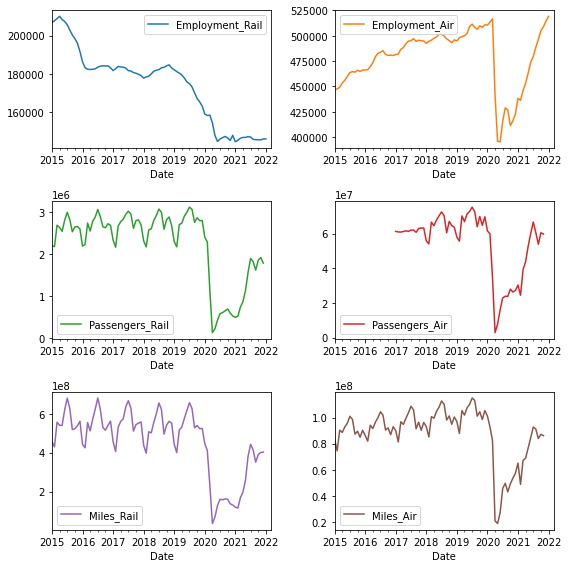

In [ ]:
#Make Date column the index
dfClean=dfFinal.copy()
dfClean.index=dfClean.Date
dfClean.drop(columns=['Date'], inplace=True)
#Plot
dfClean.plot(subplots=True, layout=(3, 2), figsize=(8,8),
              sharex=False, sharey=False, legend=True)
plt.tight_layout()

##Employment

Text(0, 0.5, 'Employees')

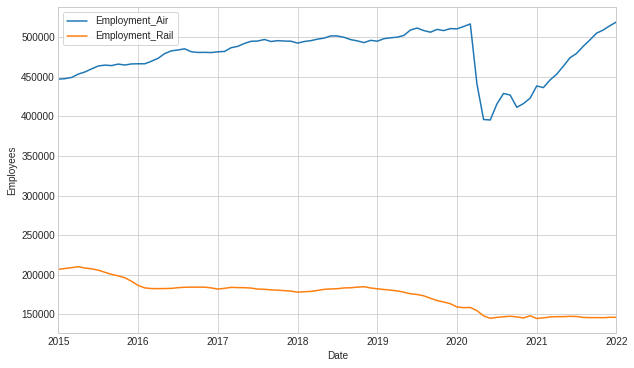

In [ ]:
dfEmployment=dfClean[['Employment_Air', 'Employment_Rail']].copy()
dfEmployment=dfEmployment.dropna()

plt.style.use('seaborn-whitegrid')
sns.color_palette("mako", as_cmap=True)
fig=dfEmployment.plot(figsize=(10,6))
plt.legend(loc='best', frameon=True)
plt.ylabel('Employees')

###Seasonal Decomposition

In [ ]:
#Seasonal plot function
def plotseasonal(d, axes ):
    d.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    d.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    d.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    d.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

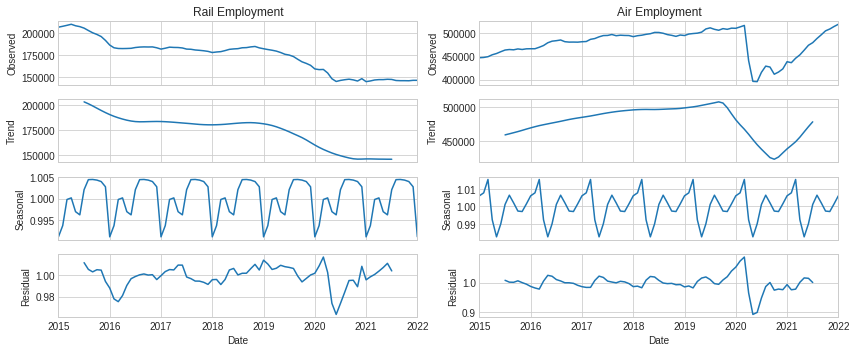

In [ ]:
#Plot Seasonal Decomposition for Employment data
decomp = sm.tsa.seasonal_decompose(dfEmployment['Employment_Rail'], model='multiplicative')
decomp1 = sm.tsa.seasonal_decompose(dfEmployment['Employment_Air'], model='multiplicative')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))
plotseasonal(decomp, axes[:,0])
plotseasonal(decomp1, axes[:,1])

headers=['Rail Employment', 'Air Employment']
for ax, col in zip(axes[0], headers):
    ax.set_title(col)

plt.tight_layout()

###ITS

In [ ]:
#Create new dataframe for interupted time series
ITS_Employment=dfFinal[['Employment_Air', 'Employment_Rail', 'Date']].copy()
ITS_Employment=ITS_Employment.dropna()
ITS_Employment=ITS_Employment.reset_index(drop=True)
#Create Week Variable
t=np.arange(1, len(ITS_Employment)+1)
ITS_Employment['t']=t.tolist()
#Create Intervention Variable
intervention=ITS_Employment[ITS_Employment['Date'] == '2020-04-01'].index[0]
d1=np.zeros(intervention).tolist()
d2=np.ones((len(ITS_Employment))-intervention).tolist()
d=d1+d2
ITS_Employment['d']=d
#Create Intervention Week Variable
p1=np.zeros(intervention).tolist()
p2=np.arange(1, len(ITS_Employment)+1-intervention).tolist()
p=p1+p2
ITS_Employment['p']=p

In [ ]:
ITS_Employment

,Employment_Air,Employment_Rail,Date,t,d,p
0,447000.0,206800.0,2015-01-01,1,0.0,0.0
1,447600.0,207800.0,2015-02-01,2,0.0,0.0
2,449200.0,208900.0,2015-03-01,3,0.0,0.0
3,453400.0,210100.0,2015-04-01,4,0.0,0.0
4,456100.0,208400.0,2015-05-01,5,0.0,0.0
...,...,...,...,...,...,...
80,496500.0,145800.0,2021-09-01,81,1.0,18.0
81,505000.0,145800.0,2021-10-01,82,1.0,19.0
82,509000.0,145700.0,2021-11-01,83,1.0,20.0
83,514400.0,146200.0,2021-12-01,84,1.0,21.0


In [ ]:
#Air Employment ITS Segmented Regressive Model
model = smf.ols(formula='Employment_Air ~ t + d + p', data=ITS_Employment)
res = model.fit()
#Rail Employment ITS Segmented Regressive Model
model = smf.ols(formula='Employment_Rail ~ t + d + p', data=ITS_Employment)
res1 = model.fit()

Text(0, 0.5, 'Employment')

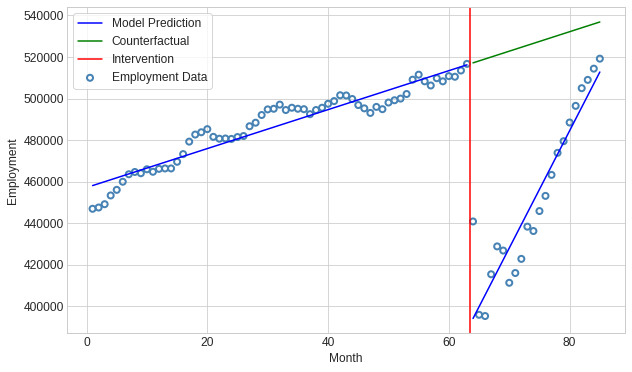

In [ ]:
plt.rcParams.update({'font.size': 12})

start = intervention
#Predictions
predictions = res.get_prediction(ITS_Employment)
y_pred = predictions.predicted_mean
#Countefactual
cf_df = ITS_Employment.copy()
cf_df["d"] = 0.0
cf_df["p"] = 0.0
cf = res.get_prediction(cf_df).summary_frame(alpha=0.05)

#Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

#Plot Employment Data
ax.scatter(ITS_Employment["t"], ITS_Employment["Employment_Air"], facecolors='none', edgecolors='steelblue', label="Employment Data", linewidths=2)

#Plot model mean Employment 
ax.plot(ITS_Employment["t"][:start], y_pred[:start], 'b-', label="Model Prediction")
ax.plot(ITS_Employment["t"][start:], y_pred[start:], 'b-')

#Plot counterfactuals
ax.plot(ITS_Employment["t"][start:], cf['mean'][start:], 'g-', label="Counterfactual")

#Plot intervention
ax.axvline(x=intervention+.5, color = 'r', label = 'Intervention')

ax.legend(loc='best', frameon=True)
plt.xlabel("Month")
plt.ylabel("Employment")

Text(0, 0.5, 'Employment')

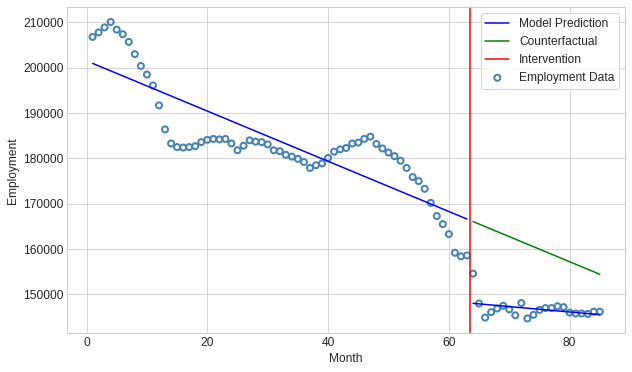

In [ ]:
plt.rcParams.update({'font.size': 12})

start = intervention
#Predictions
predictions = res1.get_prediction(ITS_Employment)
y_pred = predictions.predicted_mean
#Countefactual
cf_df = ITS_Employment.copy()
cf_df["d"] = 0.0
cf_df["p"] = 0.0
cf = res1.get_prediction(cf_df).summary_frame(alpha=0.05)

#Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

#Plot Employment Data
ax.scatter(ITS_Employment["t"], ITS_Employment["Employment_Rail"], facecolors='none', edgecolors='steelblue', label="Employment Data", linewidths=2)

#Plot model mean Employment 
ax.plot(ITS_Employment["t"][:start], y_pred[:start], 'b-', label="Model Prediction")
ax.plot(ITS_Employment["t"][start:], y_pred[start:], 'b-')

#Plot counterfactuals
ax.plot(ITS_Employment["t"][start:], cf['mean'][start:], 'g-', label="Counterfactual")

#Plot intervention
ax.axvline(x=intervention+.5, color = 'r', label = 'Intervention')

ax.legend(loc='best', frameon=True)
plt.xlabel("Month")
plt.ylabel("Employment")

###Autoarima

In [ ]:
testdf=dfEmployment['Employment_Air']
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(testdf)

(0.5073182405092512, True)

In [ ]:
from pmdarima.arima import auto_arima
model1 = auto_arima(testdf, X=ITS_Employment[["t","d","p"]], 
                    m=12,
                    stationarity=True,
                    error_action='warn',
                    trace=True, stepwise=True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.92 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2290.601, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2235.422, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2613.268, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2206.133, Time=0.78 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2234.367, Time=0.57 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2235.750, Time=0.90 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=2025.682, Time=0.33 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=2027.333, Time=0.86 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2026.863, Time=1.00 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2008.683, Time=0.49 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2023.491, Time=0.54 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept

In [ ]:
testdf2=dfEmployment['Employment_Rail']
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(testdf2)

(0.2899453787676054, True)

In [ ]:
model2 = auto_arima(testdf2, X=ITS_Employment[["t","d","p"]], 
                    m=12,
                    stationarity=True,
                    error_action='warn',
                    trace=True, stepwise=True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2151.582, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1868.769, Time=2.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2091.722, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2474.174, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1868.291, Time=1.49 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=1877.385, Time=1.35 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=4.42 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2133.913, Time=0.61 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=1878.301, Time=0.68 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1877.856, Time=0.58 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=i

###ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


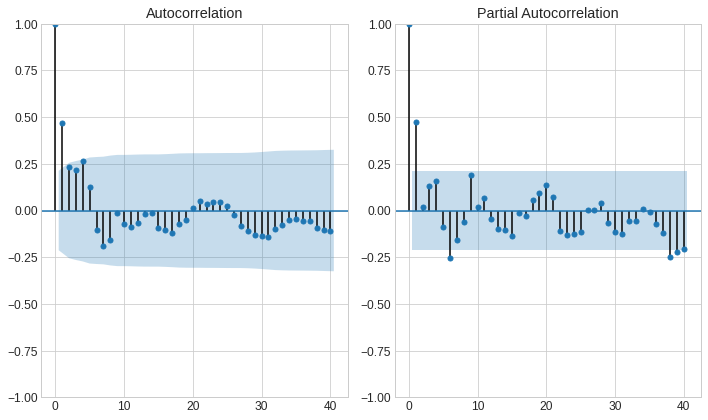

In [ ]:
fig= plt.figure(figsize=(10,6))
ax1 = sm.graphics.tsa.plot_acf(res.resid, lags=40, ax = fig.add_subplot(121))
ax2 = sm.graphics.tsa.plot_pacf(res.resid, lags=40, ax = fig.add_subplot(122))
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


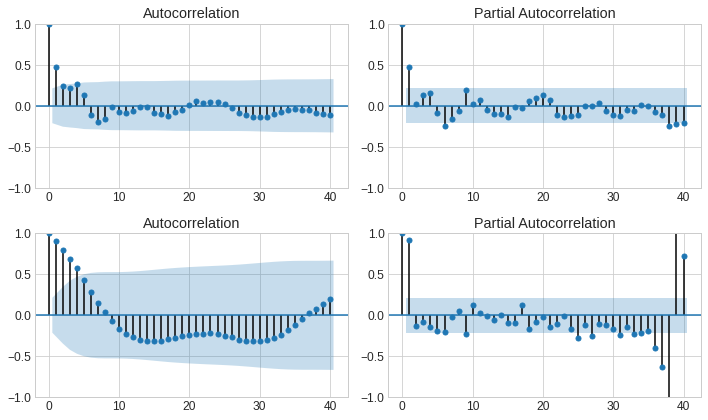

In [ ]:
fig= plt.figure(figsize=(10,6))
ax1 = sm.graphics.tsa.plot_acf(res.resid, lags=40, ax = fig.add_subplot(221))
ax2 = sm.graphics.tsa.plot_pacf(res.resid, lags=40, ax = fig.add_subplot(222))
ax3 = sm.graphics.tsa.plot_acf(res1.resid, lags=40, ax = fig.add_subplot(223))
ax4 = sm.graphics.tsa.plot_pacf(res1.resid, lags=40, ax = fig.add_subplot(224))
plt.tight_layout()

In [ ]:
a = ARIMA(ITS_Employment['Employment_Air'], exog=ITS_Employment[["t","d","p"]], order=(1, 0, 0), seasonal_order=(0,0,0,12)).fit()
a1 = ARIMA(ITS_Employment['Employment_Rail'], exog=ITS_Employment[["t","d","p"]], order=(1, 0, 0), seasonal_order=(0,0,1,12)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Text(0, 0.5, 'Employment')

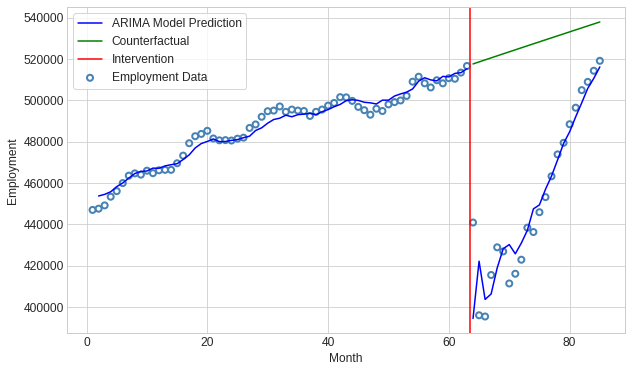

In [ ]:
plt.rcParams.update({'font.size': 12})
start = intervention
end=len(ITS_Employment)

# Get model predictions
predictions = a.get_prediction(start=1, end=end-1)
y_pred = predictions.predicted_mean
#Add ypred to df for easier plotting
arima_employment=ITS_Employment.copy()
arima_employment['y_pred']=y_pred

#Counterfactual
arima_cf = ARIMA(arima_employment['Employment_Air'][:start], exog=arima_employment['t'][:start], order=(1,0,0), seasonal_order=(0,0,0,12)).fit()
y_cf=arima_cf.get_forecast(22, exog=arima_employment['t'][start:]).summary_frame(alpha=0.05)

#Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

#Plot Employment Data
ax.scatter(arima_employment["t"], arima_employment["Employment_Air"], facecolors='none', edgecolors='steelblue', label="Employment Data", linewidths=2)

#Plot model mean Employment 
ax.plot(arima_employment["t"][:start], arima_employment['y_pred'][:start], 'b-', label="ARIMA Model Prediction")
ax.plot(arima_employment["t"][start:], arima_employment['y_pred'][start:], 'b-')

#Plot counterfactual
ax.plot(arima_employment['t'][start:], y_cf['mean'], 'g-', label="Counterfactual")

#Plot intervention
ax.axvline(x = intervention+.5, color = 'r', label = 'Intervention')

ax.legend(loc='best', frameon=True)
plt.xlabel("Month")
plt.ylabel("Employment")

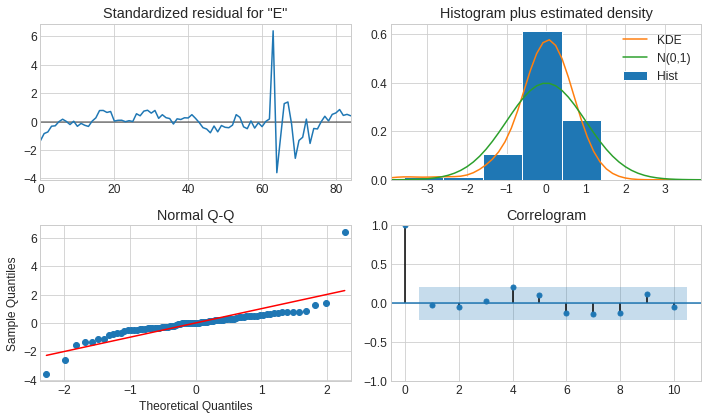

In [ ]:
#Diagnostic Plots
a.plot_diagnostics(figsize=(10,6))
plt.tight_layout()
plt.show()

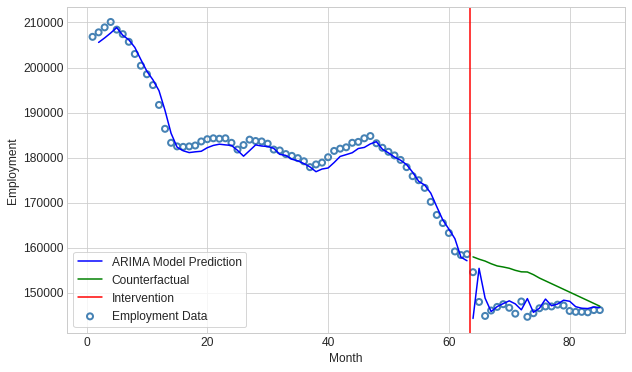

In [ ]:
plt.rcParams.update({'font.size': 12})
start = intervention
end=len(ITS_Employment)

# Get model predictions
predictions = a1.get_prediction(start=1, end=end-1)
y_pred = predictions.predicted_mean
#Add ypred to df for easier plotting
arima_employment=ITS_Employment.copy()
arima_employment['y_pred']=y_pred

#Counterfactual
arima_cf = ARIMA(arima_employment['Employment_Rail'][:start], exog=arima_employment['t'][:start], order=(1,0,0), seasonal_order=(0,0,1,12)).fit()
y_cf=arima_cf.get_forecast(22, exog=arima_employment['t'][start:]).summary_frame(alpha=0.05)

#Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

#Plot Employment Data
ax.scatter(arima_employment["t"], arima_employment["Employment_Rail"], facecolors='none', edgecolors='steelblue', label="Employment Data", linewidths=2)

#Plot model mean Employment 
ax.plot(arima_employment["t"][:start], arima_employment['y_pred'][:start], 'b-', label="ARIMA Model Prediction")
ax.plot(arima_employment["t"][start:], arima_employment['y_pred'][start:], 'b-')

#Plot counterfactual
ax.plot(arima_employment['t'][start:], y_cf['mean'], 'g-', label="Counterfactual")

#Plot intervention
ax.axvline(x = intervention+.5, color = 'r', label = 'Intervention')

#ax.legend(loc='best', frameon=True)
plt.xlabel("Month")
plt.ylabel("Employment")
ax.legend(loc='best', frameon=True)

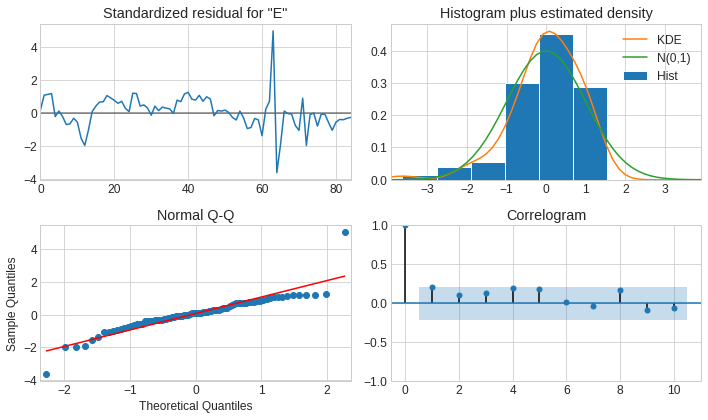

In [ ]:
#Diagnostic Plots
a1.plot_diagnostics(figsize=(10,6))
plt.tight_layout()
plt.show()

##Passengers

Text(0, 0.5, 'Passengers')

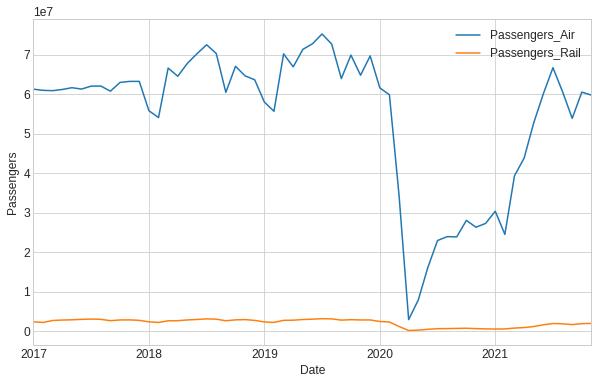

In [ ]:
dfPass=dfClean[['Passengers_Air', 'Passengers_Rail']].copy()
dfPass.dropna(inplace=True)
dfPass.plot(figsize=(10, 6))
plt.ylabel('Passengers')

###Seasonsal Decomposition

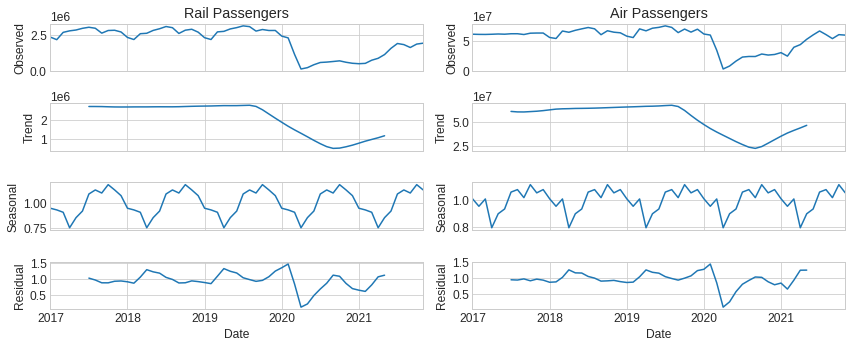

In [ ]:
decomp = sm.tsa.seasonal_decompose(dfPass['Passengers_Rail'], model='multiplicative')
decomp1 = sm.tsa.seasonal_decompose(dfPass['Passengers_Air'], model='multiplicative')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))
plotseasonal(decomp, axes[:,0])
plotseasonal(decomp1, axes[:,1])

headers=['Rail Passengers', 'Air Passengers']
for ax, col in zip(axes[0], headers):
    ax.set_title(col)

plt.tight_layout()

###ITS

In [ ]:
#Create new dataframe for interupted time series
ITS_Pass=dfFinal[['Passengers_Air', 'Passengers_Rail', 'Date']].copy()
ITS_Pass=ITS_Pass.dropna()
ITS_Pass=ITS_Pass.reset_index(drop=True)
#Create Week Variable
t=np.arange(1, len(ITS_Pass)+1)
ITS_Pass['t']=t.tolist()
#Create Intervention Variable
intervention=ITS_Pass[ITS_Pass['Date'] == '2020-03-01'].index[0]
d1=np.zeros(intervention).tolist()
d2=np.ones((len(ITS_Pass))-intervention).tolist()
d=d1+d2
ITS_Pass['d']=d
#Create Intervention Week Variable
p1=np.zeros(intervention).tolist()
p2=np.arange(1, len(ITS_Pass)+1-intervention).tolist()
p=p1+p2
ITS_Pass['p']=p

In [ ]:
#Air Passengers
model = smf.ols(formula='Passengers_Air ~ t + d + p', data=ITS_Pass)
res = model.fit()
model = smf.ols(formula='Passengers_Rail ~ t + d + p', data=ITS_Pass)
res1 = model.fit()

Text(0.5, 1.0, 'Air Passengers Before and After COVID-19')

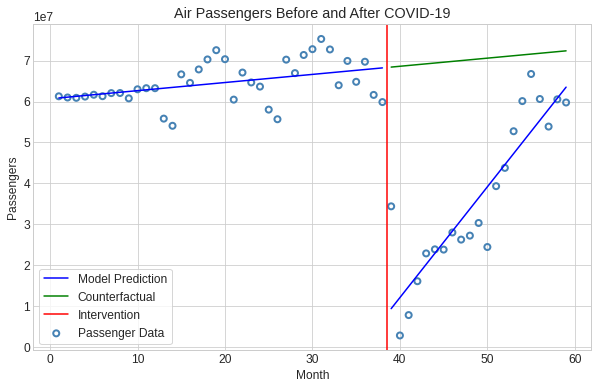

In [ ]:
plt.rcParams.update({'font.size': 12})

start = intervention
#Predictions
predictions = res.get_prediction(ITS_Pass)
y_pred = predictions.predicted_mean
#Countefactual
cf_df = ITS_Pass.copy()
cf_df["d"] = 0.0
cf_df["p"] = 0.0
cf = res.get_prediction(cf_df).summary_frame(alpha=0.05)

#Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

#Plot Passenger Data
ax.scatter(ITS_Pass["t"], ITS_Pass["Passengers_Air"], facecolors='none', edgecolors='steelblue', label="Passenger Data", linewidths=2)

#Plot model mean Passenger 
ax.plot(ITS_Pass["t"][:start], y_pred[:start], 'b-', label="Model Prediction")
ax.plot(ITS_Pass["t"][start:], y_pred[start:], 'b-')

#Plot counterfactuals
ax.plot(ITS_Pass["t"][start:], cf['mean'][start:], 'g-', label="Counterfactual")

#Plot intervention
ax.axvline(x=intervention+.5, color = 'r', label = 'Intervention')

ax.legend(loc='best', frameon=True)
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title('Air Passengers Before and After COVID-19')

Text(0.5, 1.0, 'Rail Passengers Before and After COVID-19')

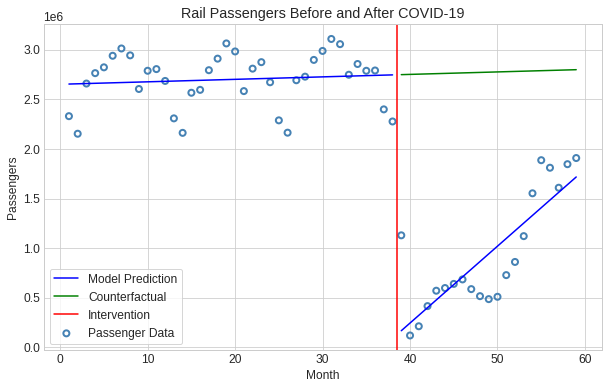

In [ ]:
plt.rcParams.update({'font.size': 12})

start = intervention
#Predictions
predictions = res1.get_prediction(ITS_Pass)
y_pred = predictions.predicted_mean
#Countefactual
cf_df = ITS_Pass.copy()
cf_df["d"] = 0.0
cf_df["p"] = 0.0
cf = res1.get_prediction(cf_df).summary_frame(alpha=0.05)

#Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

#Plot Passenger Data
ax.scatter(ITS_Pass["t"], ITS_Pass["Passengers_Rail"], facecolors='none', edgecolors='steelblue', label="Passenger Data", linewidths=2)

#Plot model mean Passenger 
ax.plot(ITS_Pass["t"][:start], y_pred[:start], 'b-', label="Model Prediction")
ax.plot(ITS_Pass["t"][start:], y_pred[start:], 'b-')

#Plot counterfactuals
ax.plot(ITS_Pass["t"][start:], cf['mean'][start:], 'g-', label="Counterfactual")

#Plot intervention
ax.axvline(x=intervention+.5, color = 'r', label = 'Intervention')

ax.legend(loc='best', frameon=True)
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title('Rail Passengers Before and After COVID-19')

###Auto ARIMA

In [ ]:
testdf3=dfPass['Passengers_Air']
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(testdf)

(0.5073182405092512, True)

In [ ]:
model3 = auto_arima(testdf3, X=ITS_Pass[["t","d","p"]], 
                    m=12,
                    stationarity=True,
                    error_action='warn',
                    trace=True, stepwise=True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2087.449, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2176.707, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2085.150, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2138.050, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2366.512, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2091.094, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2085.916, Time=0.39 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2086.405, Time=0.19 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2086.832, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2087.563, Time=0.61 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=2170.750, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=2081.933, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=2087.111, Time=0.08 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2082.479, Time=0.54 sec
 ARIMA(2,0,0)(1,0,1

In [ ]:
testdf4=dfPass['Passengers_Rail']
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(testdf)

(0.5073182405092512, True)

In [ ]:
model4 = auto_arima(testdf4, X=ITS_Pass[["t","d","p"]], 
                    m=12,
                    stationarity=True,
                    error_action='warn',
                    trace=True, stepwise=True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1714.254, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1800.461, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1710.208, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1769.890, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1997.627, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1713.123, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1710.910, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1710.537, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1711.051, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1712.384, Time=0.57 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1802.434, Time=0.08 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1709.119, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1712.533, Time=0.08 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1709.904, Time=0.42 sec
 ARIMA(2,0,0)(1,0,1

###ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


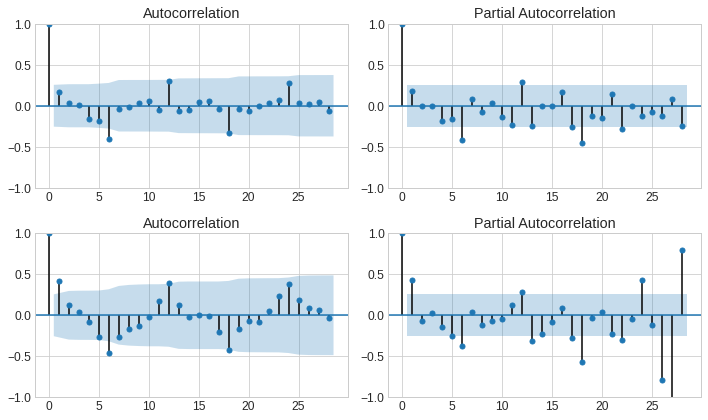

In [ ]:
#AutoCorrelation and Partial Autocorrelation for Rail (res1)
fig= plt.figure(figsize=(10,6))
ax1 = sm.graphics.tsa.plot_acf(res.resid, lags=28, ax = fig.add_subplot(221))
ax2 = sm.graphics.tsa.plot_pacf(res.resid, lags=28, ax = fig.add_subplot(222))
ax3 = sm.graphics.tsa.plot_acf(res1.resid, lags=28, ax = fig.add_subplot(223))
ax4 = sm.graphics.tsa.plot_pacf(res1.resid, lags=28, ax = fig.add_subplot(224))
plt.tight_layout()

In [ ]:
a = ARIMA(ITS_Pass['Passengers_Air'], exog=ITS_Pass[["t","d","p"]], order=(3, 0, 0), seasonal_order=(1,0,0,12)).fit()
a1 = ARIMA(ITS_Pass['Passengers_Rail'], exog=ITS_Pass[["t","d","p"]], order=(1, 0, 1), seasonal_order=(1,0,0,12)).fit()

Text(0, 0.5, 'Passengers')

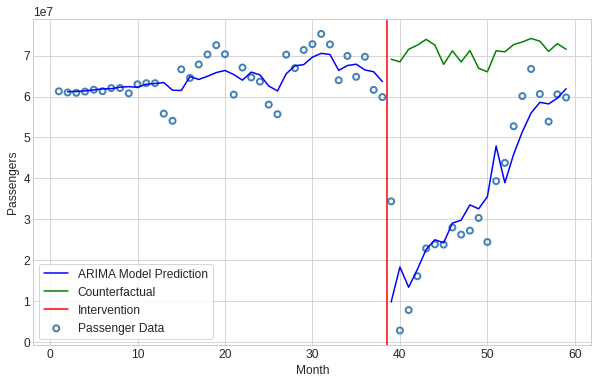

In [ ]:
#Plotting air passengers - arima

plt.rcParams.update({'font.size': 12})
start = intervention
end=len(ITS_Pass)

# Get model predictions
predictions = a.get_prediction(start=1, end=end-1)
y_pred = predictions.predicted_mean
#Add ypred to df for easier plotting
arima_pass=ITS_Pass.copy()
arima_pass['y_pred']=y_pred

#Counterfactual
arima_cf = ARIMA(arima_pass['Passengers_Air'][:start], exog=arima_pass['t'][:start], order=(3, 0, 0), seasonal_order=(1,0,0,12)).fit()
y_cf=arima_cf.get_forecast(21, exog=arima_pass['t'][start:]).summary_frame(alpha=0.05)

#Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

#Plot Employment Data
ax.scatter(arima_pass["t"], arima_pass["Passengers_Air"], facecolors='none', edgecolors='steelblue', label="Passenger Data", linewidths=2)

#Plot model mean Employment 
ax.plot(arima_pass["t"][:start], arima_pass['y_pred'][:start], 'b-', label="ARIMA Model Prediction")
ax.plot(arima_pass["t"][start:], arima_pass['y_pred'][start:], 'b-')

#Plot counterfactual
ax.plot(arima_pass['t'][start:], y_cf['mean'], 'g-', label="Counterfactual")

#Plot intervention
ax.axvline(x = intervention+.5, color = 'r', label = 'Intervention')

ax.legend(loc='best', frameon=True)
plt.xlabel("Month")
plt.ylabel("Passengers")

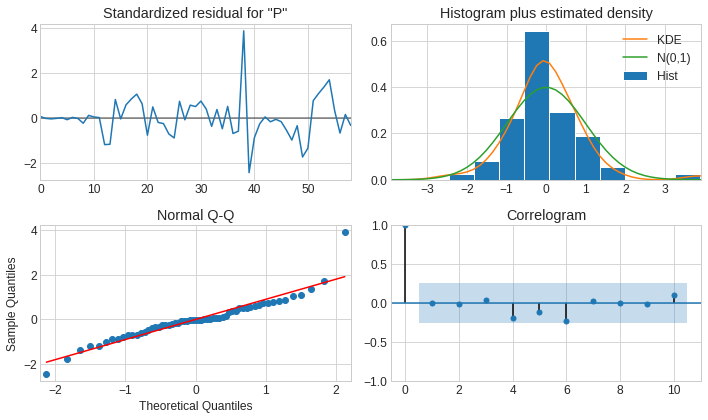

In [ ]:
#Diagnostics
a.plot_diagnostics(figsize=(10,6))
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Passengers')

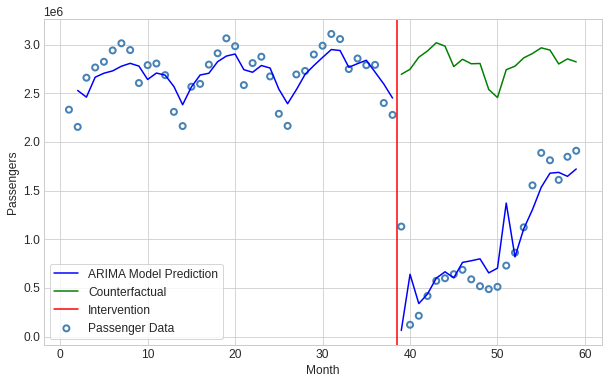

In [ ]:
plt.rcParams.update({'font.size': 12})
start = intervention
end=len(ITS_Pass)

# Get model predictions
predictions = a1.get_prediction(start=1, end=end-1)
y_pred = predictions.predicted_mean
#Add ypred to df for easier plotting
arima_pass=ITS_Pass.copy()
arima_pass['y_pred']=y_pred

#Counterfactual
arima_cf = ARIMA(arima_pass['Passengers_Rail'][:start], exog=arima_pass['t'][:start], order=(1, 0, 1), seasonal_order=(1,0,0,12)).fit()
y_cf=arima_cf.get_forecast(21, exog=arima_pass['t'][start:]).summary_frame(alpha=0.05)

#Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

#Plot Passengers Data
ax.scatter(arima_pass["t"], arima_pass["Passengers_Rail"], facecolors='none', edgecolors='steelblue', label="Passenger Data", linewidths=2)

#Plot model mean Passengers
ax.plot(arima_pass["t"][:start], arima_pass['y_pred'][:start], 'b-', label="ARIMA Model Prediction")
ax.plot(arima_pass["t"][start:], arima_pass['y_pred'][start:], 'b-')

#Plot counterfactual
ax.plot(arima_pass['t'][start:], y_cf['mean'], 'g-', label="Counterfactual")

#Plot intervention
ax.axvline(x = intervention+.5, color = 'r', label = 'Intervention')

ax.legend(loc='best', frameon=True)
plt.xlabel("Month")
plt.ylabel("Passengers")

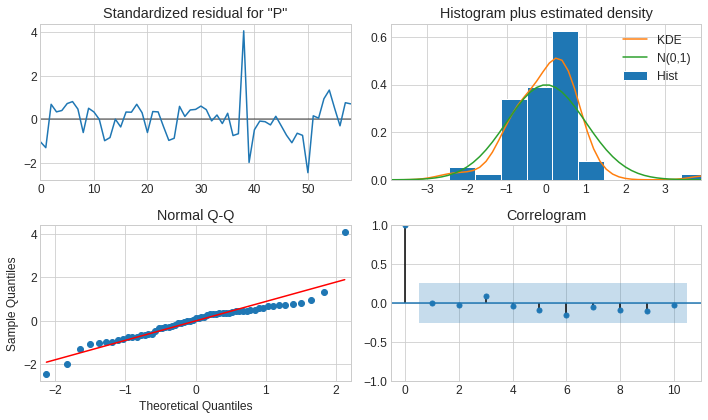

In [ ]:
#Diagnostics
a1.plot_diagnostics(figsize=(10,6))
plt.tight_layout()
plt.show()

##Miles

Text(0, 0.5, 'Passenger Miles')

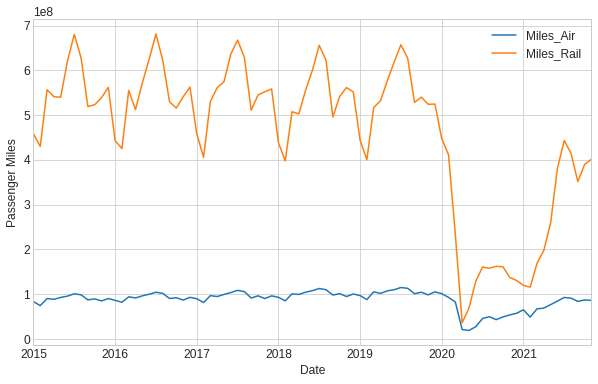

In [ ]:
dfMiles=dfClean[['Miles_Air', 'Miles_Rail']].copy()
dfMiles.dropna(inplace=True)
dfMiles.plot(figsize=(10, 6))
plt.ylabel('Passenger Miles')

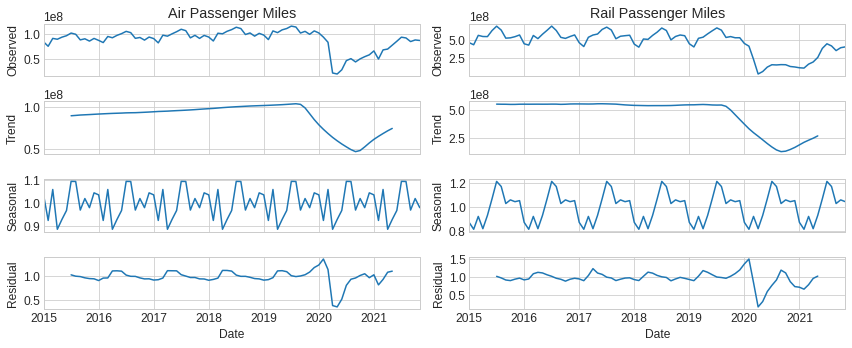

In [ ]:
decomp = sm.tsa.seasonal_decompose(dfMiles['Miles_Air'], model='multiplicative')
decomp1 = sm.tsa.seasonal_decompose(dfMiles['Miles_Rail'], model='multiplicative')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))
plotseasonal(decomp, axes[:,0])
plotseasonal(decomp1, axes[:,1])

headers=['Air Passenger Miles', 'Rail Passenger Miles']
for ax, col in zip(axes[0], headers):
    ax.set_title(col)

plt.tight_layout()

In [ ]:
#Create new dataframe for interupted time series
ITS_Miles=dfFinal[['Miles_Air', 'Miles_Rail', 'Date']].copy()
ITS_Miles=ITS_Miles.dropna()
ITS_Miles=ITS_Miles.reset_index(drop=True)
#Create Week Variable
t=np.arange(1, len(ITS_Miles)+1)
ITS_Miles['t']=t.tolist()
#Create Intervention Variable
intervention=ITS_Miles[ITS_Miles['Date'] == '2020-03-01'].index[0]
d1=np.zeros(intervention).tolist()
d2=np.ones((len(ITS_Miles))-intervention).tolist()
d=d1+d2
ITS_Miles['d']=d
#Create Intervention Week Variable
p1=np.zeros(intervention).tolist()
p2=np.arange(1, len(ITS_Miles)+1-intervention).tolist()
p=p1+p2
ITS_Miles['p']=p

In [ ]:
model = smf.ols(formula='Miles_Air ~ t + d + p', data=ITS_Miles)
res = model.fit()
model = smf.ols(formula='Miles_Rail ~ t + d + p', data=ITS_Miles)
res1 = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


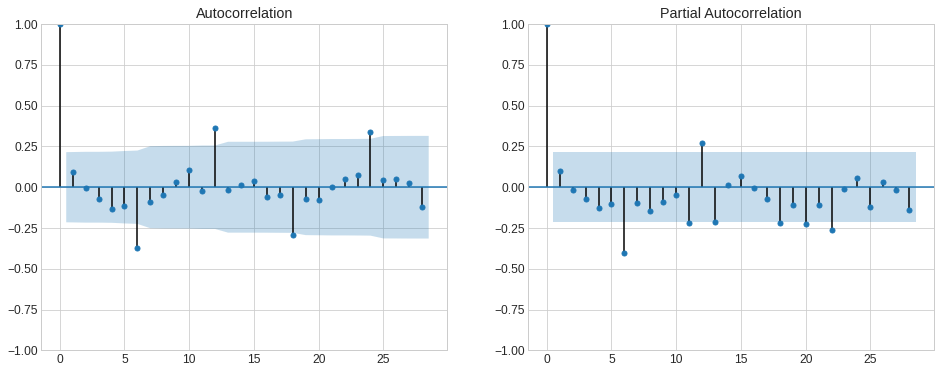

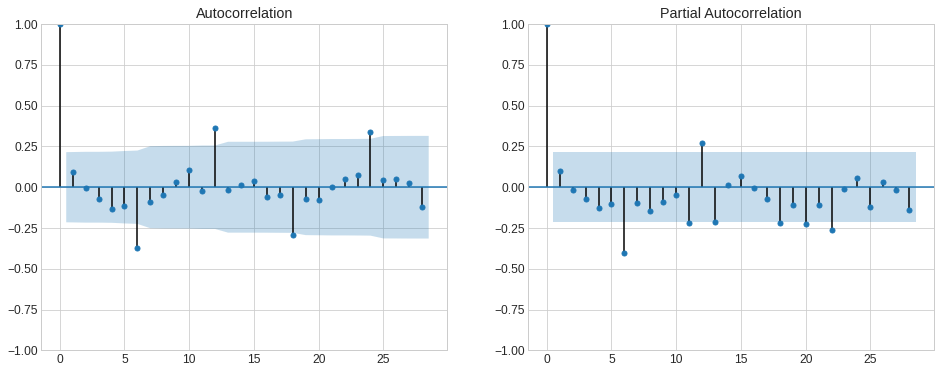

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,6), squeeze=False)
sm.graphics.tsa.plot_acf(res.resid, ax=axes[0,0], lags=28)
sm.graphics.tsa.plot_pacf(res.resid, ax=axes[0,1], lags=28)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


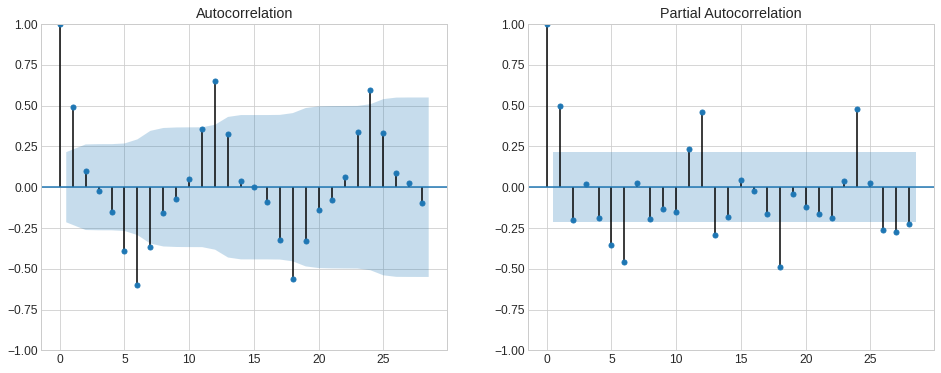

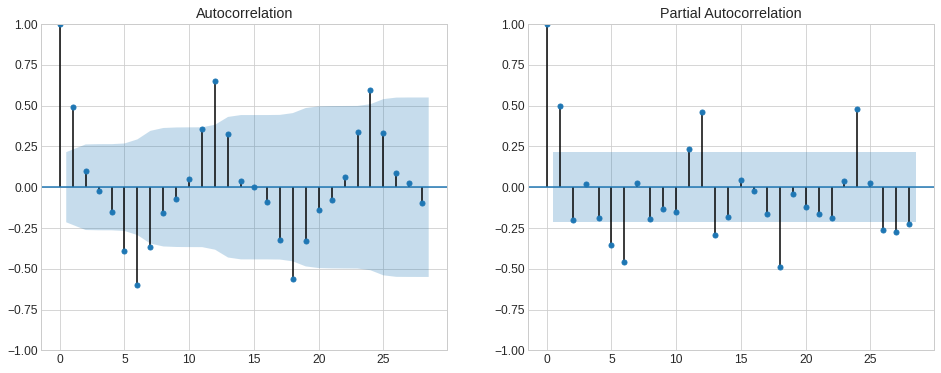

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,6), squeeze=False)
sm.graphics.tsa.plot_acf(res1.resid, ax=axes[0,0], lags=28)
sm.graphics.tsa.plot_pacf(res1.resid, ax=axes[0,1], lags=28)

In [ ]:
testdf5=dfMiles['Miles_Air']
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(testdf)

(0.5073182405092512, True)

In [ ]:
model5 = auto_arima(testdf5, X=ITS_Miles[["t","d","p"]], 
                    m=12,
                    stationarity=True,
                    error_action='warn',
                    trace=True, stepwise=True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2978.754, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3129.805, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2986.853, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3075.609, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3428.246, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=2979.177, Time=0.55 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=2977.713, Time=0.54 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=2977.102, Time=2.02 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=2979.089, Time=2.52 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=2977.546, Time=2.08 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=2979.531, Time=0.88 sec
 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=2976.190, Time=1.02 sec
 ARIMA(2,0,1)(1,0,1)[12] inte

In [ ]:
testdf6=dfMiles['Miles_Rail']
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(testdf)

(0.5073182405092512, True)

In [ ]:
model6 = auto_arima(testdf6, X=ITS_Miles[["t","d","p"]], 
                    m=12,
                    stationarity=True,
                    error_action='warn',
                    trace=True, stepwise=True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3268.066, Time=1.16 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3437.369, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3271.905, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3377.537, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3735.271, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=3278.855, Time=0.25 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=3271.970, Time=0.84 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=3289.932, Time=0.22 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=3274.967, Time=1.02 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=3268.840, Time=1.03 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=3268.192, Time=0.47 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept

In [ ]:
a = ARIMA(ITS_Miles['Miles_Air'], exog=ITS_Miles[["t","d","p"]], order=(1, 0, 1), seasonal_order=(2,0,0,12)).fit()
a1 = ARIMA(ITS_Miles['Miles_Rail'], exog=ITS_Miles[["t","d","p"]], order=(1, 0, 1), seasonal_order=(1,0,1,12)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Text(0, 0.5, 'Miles')

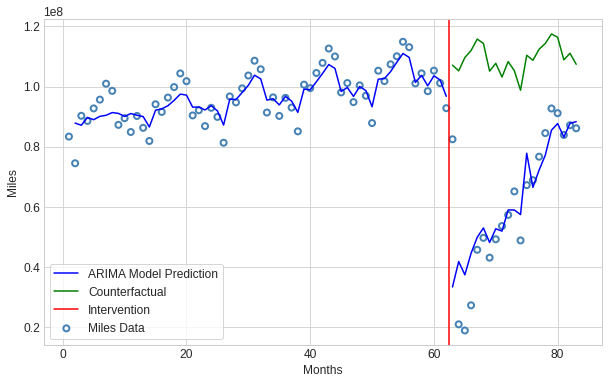

In [ ]:
#Plotting air miles - arima

plt.rcParams.update({'font.size': 12})
start = intervention
end=len(ITS_Miles)

# Get model predictions
predictions = a.get_prediction(start=1, end=end-1)
y_pred = predictions.predicted_mean
#Add ypred to df for easier plotting
arima_pass=ITS_Miles.copy()
arima_pass['y_pred']=y_pred

#Counterfactual
arima_cf = ARIMA(arima_pass['Miles_Air'][:start], exog=arima_pass['t'][:start], order=(1, 0, 1), seasonal_order=(2,0,0,12)).fit()
y_cf=arima_cf.get_forecast(21, exog=arima_pass['t'][start:]).summary_frame(alpha=0.05)

#Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

#Plot Employment Data
ax.scatter(arima_pass["t"], arima_pass["Miles_Air"], facecolors='none', edgecolors='steelblue', label="Miles Data", linewidths=2)

#Plot model mean Employment 
ax.plot(arima_pass["t"][:start], arima_pass['y_pred'][:start], 'b-', label="ARIMA Model Prediction")
ax.plot(arima_pass["t"][start:], arima_pass['y_pred'][start:], 'b-')

#Plot counterfactual
ax.plot(arima_pass['t'][start:], y_cf['mean'], 'g-', label="Counterfactual")

#Plot intervention
ax.axvline(x = intervention+.5, color = 'r', label = 'Intervention')

ax.legend(loc='best', frameon=True)
plt.xlabel("Months")
plt.ylabel("Miles")

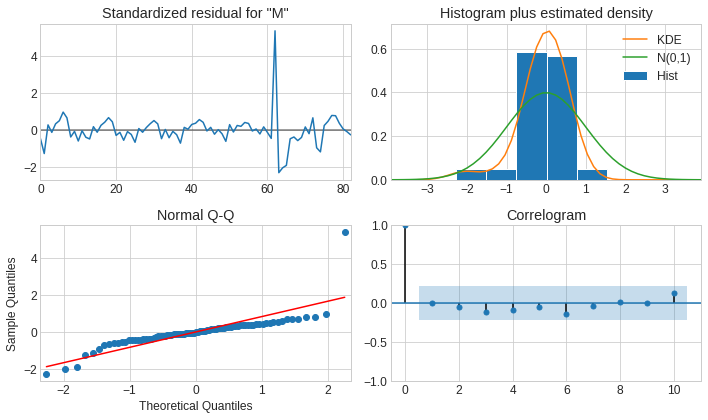

In [ ]:
#Diagnostics
a.plot_diagnostics(figsize=(10,6))
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Miles')

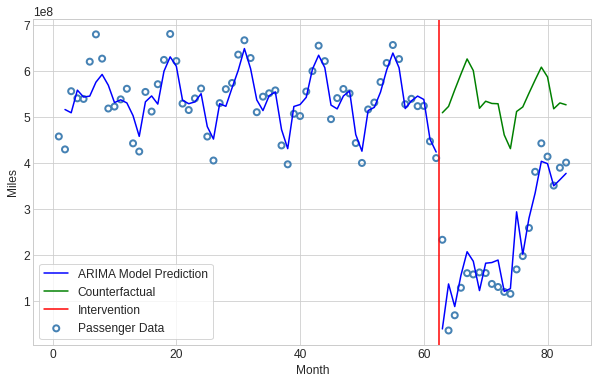

In [ ]:
plt.rcParams.update({'font.size': 12})
start = intervention
end=len(ITS_Miles)

# Get model predictions
predictions = a1.get_prediction(start=1, end=end-1)
y_pred = predictions.predicted_mean
#Add ypred to df for easier plotting
arima_pass=ITS_Miles.copy()
arima_pass['y_pred']=y_pred

#Counterfactual
arima_cf = ARIMA(arima_pass['Miles_Rail'][:start], exog=arima_pass['t'][:start], order=(1, 0, 1), seasonal_order=(1,0,1,12)).fit()
y_cf=arima_cf.get_forecast(21, exog=arima_pass['t'][start:]).summary_frame(alpha=0.05)

#Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))

#Plot Passengers Data
ax.scatter(arima_pass["t"], arima_pass["Miles_Rail"], facecolors='none', edgecolors='steelblue', label="Passenger Data", linewidths=2)

#Plot model mean Passengers
ax.plot(arima_pass["t"][:start], arima_pass['y_pred'][:start], 'b-', label="ARIMA Model Prediction")
ax.plot(arima_pass["t"][start:], arima_pass['y_pred'][start:], 'b-')

#Plot counterfactual
ax.plot(arima_pass['t'][start:], y_cf['mean'], 'g-', label="Counterfactual")

#Plot intervention
ax.axvline(x = intervention+.5, color = 'r', label = 'Intervention')

ax.legend(loc='best', frameon=True)
plt.xlabel("Month")
plt.ylabel("Miles")

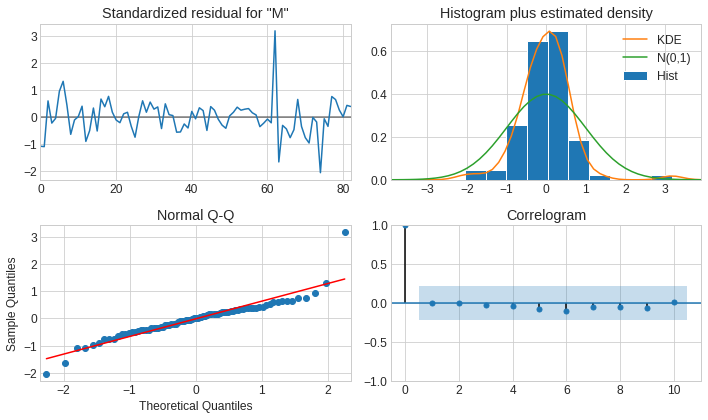

In [ ]:
#Diagnostics
a1.plot_diagnostics(figsize=(10,6))
plt.tight_layout()
plt.show()

In [ ]:
#Output Tables
#ITS_Employment.to_csv('ITS_Employment.csv')
#ITS_Pass.to_csv('ITS_Pass.csv')
#ITS_Miles.to_csv('ITS_Miles.csv')